# Introduction

This example demonstrates using a network pretrained on ImageNet for classification. The model used was converted from the VGG_CNN_S model (http://arxiv.org/abs/1405.3531) in [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). 

For details of the conversion process, see the example notebook "Using a Caffe Pretrained Network - CIFAR10".

### License
The model is licensed for non-commercial use only

### Download the model (393 MB)

In [ ]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg_cnn_s.pkl

# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import LocalResponseNormalization2DLayer as NormLayer
from lasagne.utils import floatX

### Define the network

In [4]:
net = {}
net['input'] = InputLayer((None, 3, 224, 224))
net['conv1'] = ConvLayer(net['input'], num_filters=96, filter_size=7, stride=2, flip_filters=False)
net['norm1'] = NormLayer(net['conv1'], alpha=0.0001) # caffe has alpha = alpha * pool_size
net['pool1'] = PoolLayer(net['norm1'], pool_size=3, stride=3, ignore_border=False)
net['conv2'] = ConvLayer(net['pool1'], num_filters=256, filter_size=5, flip_filters=False)
net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, ignore_border=False)
net['conv3'] = ConvLayer(net['pool2'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['conv4'] = ConvLayer(net['conv3'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['conv5'] = ConvLayer(net['conv4'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['pool5'] = PoolLayer(net['conv5'], pool_size=3, stride=3, ignore_border=False)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['drop7'], num_units=1000, nonlinearity=lasagne.nonlinearities.softmax)
output_layer = net['fc8']

### Load the model parameters and metadata

In [5]:
import pickle

try:
    values = pickle.load(open('vgg19_normalized.pkl','rb'))['param values']
except UnicodeDecodeError:
    values = pickle.load(open('vgg19_normalized.pkl','rb'),encoding='Latin-1')['param values'] # python3
CLASSES = model['synset words']
MEAN_IMAGE = model['mean image']

lasagne.layers.set_all_param_values(output_layer, model['values'])

# Trying it out

### Get some test images
We'll download the ILSVRC2012 validation URLs and pick a few at random

In [6]:
import urllib

index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(23)
np.random.shuffle(image_urls)
image_urls = image_urls[:5]

### Helper to fetch and preprocess images

In [7]:
import io
import skimage.transform

def prep_image(url):
    ext = url.split('.')[-1]
    im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

### Process test images and print top 5 predicted labels

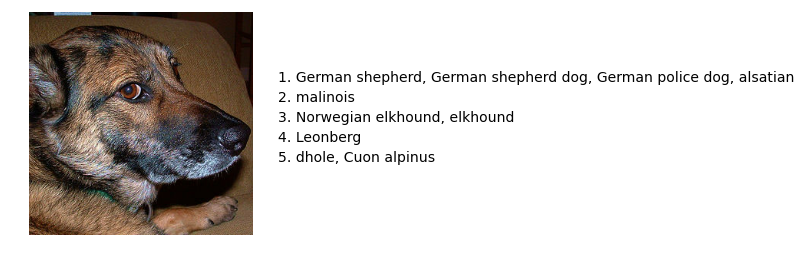

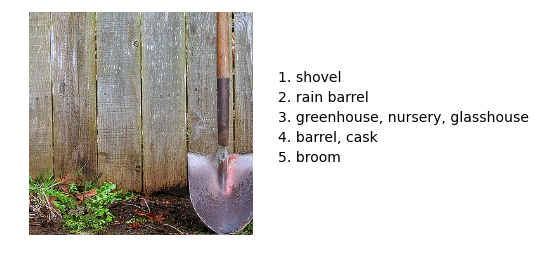

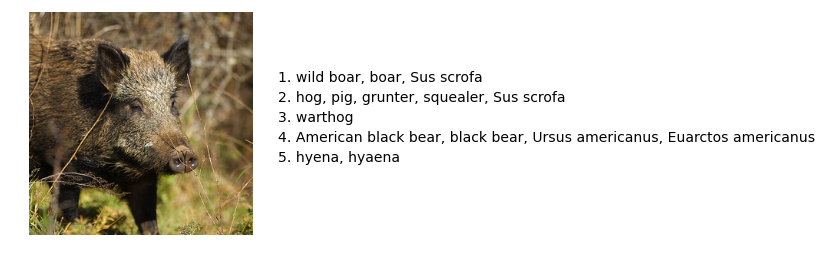

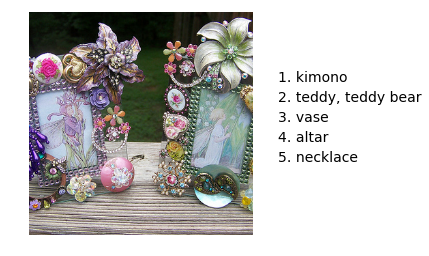

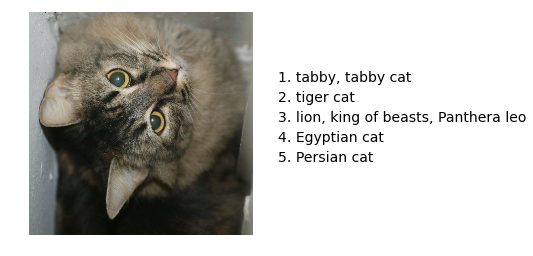

In [8]:
for url in image_urls:
    try:
        rawim, im = prep_image(url)

        prob = np.array(lasagne.layers.get_output(output_layer, im, deterministic=True).eval())
        top5 = np.argsort(prob[0])[-1:-6:-1]

        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')
        for n, label in enumerate(top5):
            plt.text(250, 70 + n * 20, '{}. {}'.format(n+1, CLASSES[label]), fontsize=14)
    except IOError:
        print('bad url: ' + url)